In [1]:
%load_ext autoreload
%autoreload 2

# 1. Patch descriptors register in 3D for 642 templates

In [2]:
import glob
import os

# Load templates
template_path = "datasets/bop23_challenge/datasets/templates_pyrender/icbin_642/obj_000001"
template_files = sorted(glob.glob(os.path.join(template_path, "*.png")), key=os.path.getmtime)

In [3]:
from PIL import Image
import numpy as np

templates = [np.array(Image.open(template_file).convert("RGB").resize((420,420)))[:,:,:3] for template_file in template_files] # This image has 4 channels- the last one is not crucial - maybe about opacity

In [4]:
import torchvision.transforms as T
import torch.nn.functional as F
import torch

def patches_feature_extraction(template_patches, dinov2_vitl14, device):
    # crop_rgb: numpy array
    # temps = np.transpose(np.array(template_patches), (0,2,3,1))
    rgb_normalize = T.Compose(
        [
            T.ToTensor(),
            T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ]
    )
    normalized_patches = torch.stack([rgb_normalize(patch) for patch in template_patches])
    layers_list = list(range(18))
    torch.cuda.empty_cache()
    with torch.no_grad(): 
        feature_patches= dinov2_vitl14.module.get_intermediate_layers(normalized_patches.to(device), n=layers_list, reshape=True, return_class_token=True)
    return feature_patches[-1][0] # Choose the last features as the feature after the 18th layer, 1 fo class token

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
dinov2_vitl14.patch_size = 14
if torch.cuda.is_available():
    dinov2_vitl14 = torch.nn.DataParallel(dinov2_vitl14).to(device)  # Use DataParallel for multiple GPUs

Using cache found in /home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main


In [24]:
batch_size = 4
template_batches = [templates[i:i+batch_size] for i in range(0, len(templates), batch_size)]
patch_features= list()

for batch in template_batches:
    torch.cuda.empty_cache()
    batch_feature = patches_feature_extraction(batch, dinov2_vitl14, device)
    patch_features.append(batch_feature.to('cpu'))
    del batch_feature
patch_features = torch.cat(patch_features).permute(0,2,3,1)

In [7]:
del dinov2_vitl14

In [25]:
patch_features = patch_features.reshape(642,-1,1024)
patch_features.shape

torch.Size([642, 900, 1024])

# 2. Filter out invalid templates
Resize the mask to 30*30 and then choose the pixel position e.g (1,1) then check if mask[1,1] = 1 then the patch [1,1] is valid, otherwise it isn't 

In [26]:
# resize templates by 30,30
resized_templates = [np.array(Image.open(template_file).convert("RGB").resize((30,30)))[:,:,:3] for template_file in template_files] # This image has 4 channels- the last one is not crucial - maybe about opacity

In [29]:
# Mask out the templates by clampping at 0,1 
masks = np.clip(np.sum(resized_templates, axis=-1), 0, 1).reshape(642,-1)

In [30]:
masks.shape

(642, 900)

In [38]:
num_valid_patches = list() # List of numbers of valid patches for each template
valid_patch_features = list()
for patch_feature, mask in zip(patch_features, masks):
    valid_patches = patch_feature[mask==1]
    valid_patch_features.append(valid_patches)
    num_valid_patches.append(valid_patches.shape[0]) # Append number of  valid patches for the template to the list
valid_patch_features = torch.cat(valid_patch_features)

In [42]:
print(valid_patch_features.shape)
print(len(num_valid_patches), num_valid_patches)

torch.Size([47568, 1024])
642 [42, 52, 48, 48, 51, 51, 54, 55, 56, 53, 53, 59, 56, 55, 56, 58, 63, 58, 63, 59, 62, 59, 59, 60, 61, 60, 64, 62, 64, 64, 64, 67, 66, 68, 66, 63, 66, 68, 66, 67, 68, 66, 63, 64, 68, 68, 68, 67, 64, 66, 68, 72, 68, 70, 71, 71, 69, 67, 69, 70, 68, 71, 74, 73, 71, 71, 74, 69, 71, 72, 71, 74, 71, 71, 72, 73, 73, 75, 75, 75, 71, 73, 75, 73, 75, 75, 75, 73, 73, 75, 75, 76, 75, 75, 75, 71, 74, 74, 72, 77, 75, 78, 75, 73, 74, 76, 76, 78, 76, 77, 80, 77, 74, 73, 80, 77, 76, 78, 76, 74, 79, 78, 74, 74, 78, 77, 78, 77, 79, 78, 75, 74, 74, 75, 78, 79, 81, 79, 75, 75, 80, 79, 80, 80, 80, 76, 78, 80, 78, 79, 81, 80, 76, 76, 81, 80, 80, 79, 78, 78, 82, 81, 77, 77, 82, 81, 80, 79, 82, 80, 77, 79, 77, 77, 82, 82, 81, 80, 78, 77, 82, 78, 80, 79, 79, 82, 81, 82, 80, 78, 78, 79, 80, 79, 78, 82, 80, 77, 78, 81, 81, 81, 80, 81, 80, 78, 78, 76, 77, 81, 81, 81, 80, 80, 80, 76, 77, 76, 77, 80, 80, 76, 76, 78, 78, 74, 76, 77, 76, 74, 78, 78, 79, 78, 74, 73, 77, 76, 74, 73, 78, 77, 7

In [44]:
import numpy as np
from sklearn.decomposition import PCA

# Apply PCA with the 256 components to reduce dimensionality of the features
pca = PCA(n_components=256)
pca_patches_descriptors = pca.fit_transform(np.array(valid_patch_features.cpu()))
pca_patches_descriptors.shape

(47568, 256)

# 2. Perform Kmean clustering for all patch descriptors from templates (2048 clusters)

In [45]:
# https://github.com/facebookresearch/faiss/wiki/Faiss-building-blocks:-clustering,-PCA,-quantization
import faiss
ncentroids = 2048
niter = 20
verbose = True
d = pca_patches_descriptors.shape[1]
kmeans = faiss.Kmeans(d, ncentroids, niter=niter, verbose=verbose, gpu=True)
kmeans.train(pca_patches_descriptors)

WARNING clustering 47568 points to 2048 centroids: please provide at least 79872 training points


Clustering 47568 points in 256D to 2048 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
  Iteration 19 (0.27 s, search 0.15 s): objective=2.22272e+07 imbalance=1.167 nsplit=0       


22227172.0

In [46]:
# Assign labels to the data points
labels = kmeans.index.search(pca_patches_descriptors, 1)[1]
labels.shape

(47568, 1)

In [47]:
templates_labels = list()
start_idx = 0
for num in num_valid_patches:
    end_idx = start_idx + num
    template_labels = labels[start_idx:end_idx].reshape(-1)
    templates_labels.append(template_labels)
    start_idx = end_idx

In [48]:
import math

def calculate_templates_vector(templates_labels, num_clusters = 2048):
    # Calculate bag-of-words descriptors of the templates

    templates_vector = list()
    all_occurrences = [np.bincount(templates_label, minlength=2048) for templates_label in templates_labels]
    ni_array = np.sum(np.array(all_occurrences), axis = 0)
    N = len(templates_labels) # Number of templates
    for t in range(len(templates_labels)):
        template_vector = list()
        occurrences = np.bincount(templates_labels[t], minlength=2048)
        for i in range(num_clusters):
            n_it = occurrences[i]
            nt = len(templates_labels[t])
            ni = ni_array[i]
            bi = n_it / nt * math.log(N / ni)
            template_vector.append(bi)
        templates_vector.append(np.array(template_vector))
    return templates_vector
templates_vector = calculate_templates_vector(templates_labels = templates_labels, num_clusters = 2048)

In [49]:
np.max(templates_vector[0])

0.4176330249533452

# 3. Retrieving similar templates

In [71]:
# Load image crop 
crop_rgb = np.array(Image.open("cnos_analysis/crop_proposals/crop1.png").convert("RGB").resize((420,420))) # (124, 157, 3)
resized_crop_rgb = np.array(Image.open("cnos_analysis/crop_proposals/crop1.png").convert("RGB").resize((30,30))) # (124, 157, 3)
crop_mask = np.clip(np.sum(resized_crop_rgb, axis=-1), 0, 1).reshape(-1)

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
dinov2_vitl14.patch_size = 14
if torch.cuda.is_available():
    dinov2_vitl14 = torch.nn.DataParallel(dinov2_vitl14).to(device)  # Use DataParallel for multiple GPUs

Using cache found in /home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main


In [69]:
crop_feature = patches_feature_extraction(np.expand_dims(crop_rgb, 0), dinov2_vitl14, device).permute(0,2,3,1).reshape(-1,1024)

In [70]:
del dinov2_vitl14

In [73]:
valid_crop_features = crop_feature[crop_mask==1]
valid_crop_features.shape

torch.Size([444, 1024])

In [74]:
from sklearn.decomposition import PCA

pca = PCA(n_components=256)
pca_crop_patches_descriptors = pca.fit_transform(np.array(valid_crop_features.cpu()))
pca_crop_patches_descriptors.shape

(444, 256)

In [75]:
# Assign labels to the data points
crop_labels = kmeans.index.search(pca_crop_patches_descriptors, 1)[1].reshape(-1)
crop_labels.shape

(444,)

In [79]:
import math
# For word_i, term frequency = occurences of word_i within the crop / number of occurences of word_i in all templates). 
def calculate_crop_vector(crop_labels, templates_labels, num_clusters = 2048):
    # Calculate bag-of-words descriptors of the templates
    all_occurrences_crop = np.bincount(crop_labels, minlength=2048)

    all_occurrences_templates = [np.bincount(templates_label, minlength=2048) for templates_label in templates_labels]
    ni_array = np.sum(np.array(all_occurrences_templates), axis = 0)
    N = len(templates_labels) # Number of templates = 642 

    crop_vector = list()
    for i in range(num_clusters):
        n_it = all_occurrences_crop[i]
        nt = crop_labels.shape[0] # Number of words in crop = 400 
        ni = ni_array[i]
        bi = n_it / nt * math.log(N / ni)
        crop_vector.append(bi)
    return torch.tensor(crop_vector).view(1,-1) # Goal having features size (1,2048)
crop_vector = calculate_crop_vector(crop_labels = crop_labels, templates_labels = templates_labels, num_clusters = 2048)

In [80]:
crop_vector.shape

torch.Size([1, 2048])

In [81]:
concat_templates_vector = torch.cat([torch.tensor(vector).view(1,-1) for vector in templates_vector]) # Goal torch.Size([642, 2048])

In [82]:
concat_templates_vector.shape 

torch.Size([642, 2048])

# 3. Retrieve top similar pose

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from src.model.loss import PairwiseSimilarity, Similarity
from torchvision.io import read_image
metric = Similarity() # cnos  uses PairwiseSimilariy - what is the difference between Similarity and Pairwise Similarity ?

def calculate_similarity(crop_rgb, feature_decriptors, ref_features, metric, synthetic=False):
    # get scores per proposal
    scores = metric(feature_decriptors[:, None, :], ref_features[None, :, :]) # should get  # N_proposals x N_objects x N_templates -get only 1,42 as num_prosals*num_templates instead
    score_per_detection, similar_template_indices = torch.topk(scores, k=5, dim=-1) # get top 5 most similar templates
    # get the final confidence score
    score_per_detection = torch.mean(
        score_per_detection, dim=-1
    ) 
    # Check the confidence scores for the similar templates
    similar_scores = scores[:, similar_template_indices[0].to("cpu")]

    similar_templates = []
    for i in range(len(similar_template_indices[0])):
        if synthetic:
            img = read_image(f"datasets/bop23_challenge/datasets/templates_pyrender/icbin_642/obj_000001/{(similar_template_indices[0][i]):06d}.png")            
        else:
            img = read_image(f"cnos_analysis/real_images_templates/icbin/obj_000001_original/{(similar_template_indices[0][i]):06d}.png")        
        similar_templates.append(img)
    template_images = torch.stack(similar_templates)

    # Display the crop
    plt.imshow(crop_rgb)
    plt.axis('off')  # Optional: Turn off the axis
    plt.show()

    print("top 5 confidence scores", similar_scores)
    print("final average confidence score", score_per_detection)

    width = 50
    height = 50
    fig = plt.figure(figsize=(15, 15))
    columns = 3
    rows = 2

    for index in range(len(template_images)):
        fig.add_subplot(rows, columns, index + 1)
        img = template_images[index].permute(1, 2, 0)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Top Image {index + 1}')

    plt.tight_layout()
    plt.show()

    return

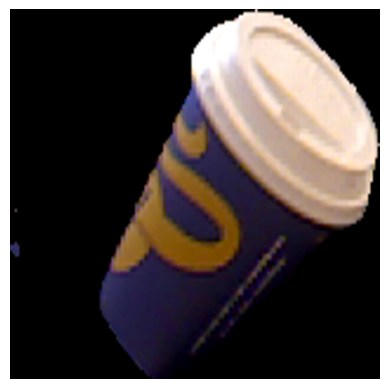

top 5 confidence scores tensor([[0.1136, 0.1131, 0.1073, 0.1067, 0.1056]], dtype=torch.float64)
final average confidence score tensor([0.1093], dtype=torch.float64)


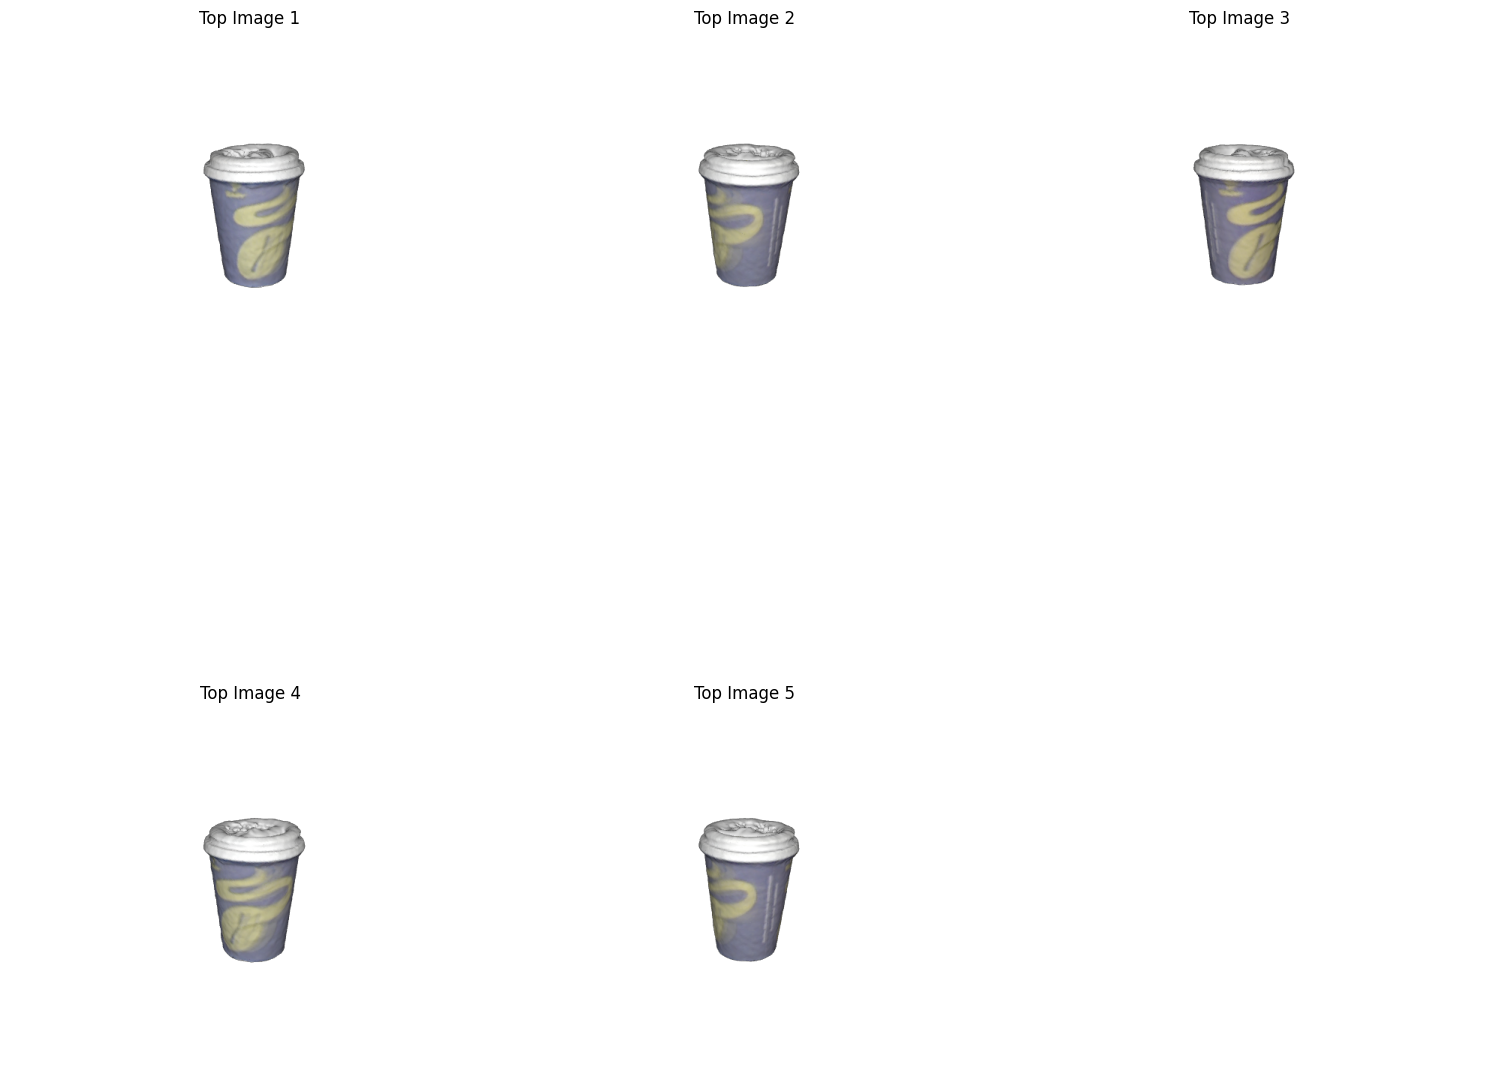

In [124]:
calculate_similarity(crop_rgb, crop_vector, concat_templates_vector, metric, synthetic=True)

# 6 Test
On small crop, etc

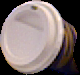

In [126]:
small_crop_rgb = np.array(Image.open("cnos_analysis/crop_proposals/crop2.png").convert("RGB")) # (124, 157, 3)
Image.open("cnos_analysis/crop_proposals/crop2.png")